# MCMC

In [1]:
from statistics import NormalDist

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr #, norm

### Define target and candidate distributions
We can define our target distribution as:

$$p(x) = \frac{f(x)}{C}$$

Where $C$ is a _normalizing constant_.

Moving forward we will be operating under the assumption that we do not know the target distribution entirely. 

In [2]:
#this function is the numerator of the target distribution
def f(x):
    if x >= 1:
        return np.exp(-(x-1)/2) + np.exp(-(x-1)**2)
    else: 
        return np.exp((x-1)/3) + np.exp((x-1)**3)

In [3]:
#normal PDF
def g(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

In [4]:
class CandidateDistribution:
    def __init__(self, dist_class, **kwargs):    
        self.dist = dist_class(**kwargs)
        self.kwargs = kwargs
        
    def sample(self, n=1):
        return self.dist.samples(n=n)
        
    def get_likelihood_of_sample(self, x):
        
        if isinstance(x, np.ndarray):
            return [self.dist.pdf(val) for val in x]
        return self.dist.pdf(x)


## Draw Target Distribution
We can note that $f(x)$ and $p(x)$ are proportional to each other. However, we do not know the proportionality constant. 

In [5]:
NORM_CONST = 7.16556 # this is from wolfram alpha :) 

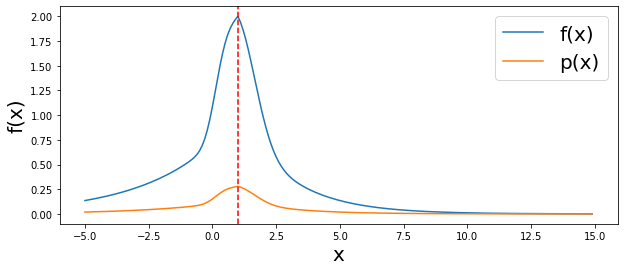

In [6]:
x_vals = np.arange(-5,15,.1)
f_vals = [f(x) for x in x_vals]
p_vals = [f/NORM_CONST for f in f_vals]

plt.figure(figsize=(10,4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, p_vals)
plt.legend(['f(x)', 'p(x)'], fontsize=20)
plt.xlabel('x', fontsize=20)
plt.ylabel('f(x)', fontsize=20)
plt.axvline(1, color='r', linestyle='--')
plt.show()

In [7]:
TRUE_EXP = 1.94709 / NORM_CONST
print(TRUE_EXP) # this is the answer we wish to achieve

0.2717289367474419


### Case 1: Accept-Reject with $N(0, 3)$

In [8]:
cd = CandidateDistribution(NormalDist, mu=0, sigma=3)

In [9]:
def plot_target_vs_proposal(M=1, zoom=False):
    x_vals = np.arange(-30,30,.1)
    f_vals = [f(x) for x in x_vals]
    g_vals = np.array(cd.get_likelihood_of_sample(x_vals))

    plt.figure(figsize=(10,4))
    plt.plot(x_vals, f_vals)
    plt.plot(x_vals, M*g_vals)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    plt.legend(['f(x)', 'Mg(x)'], fontsize=20)
    
    if zoom:
        plt.ylim(0, 0.05)
    
    plt.title("M=%s"%M, fontsize=20)
    plt.show()

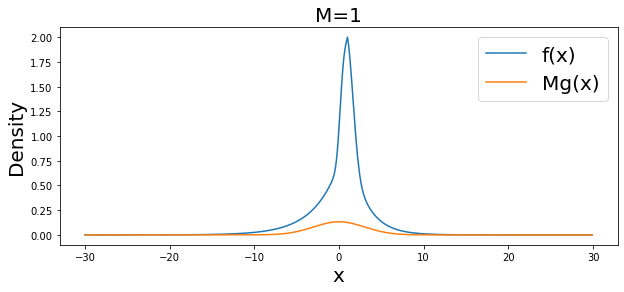

In [10]:
plot_target_vs_proposal()

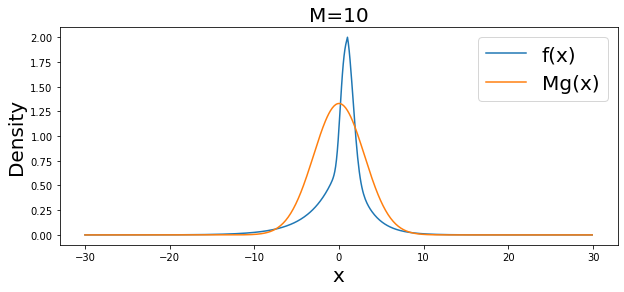

In [11]:
plot_target_vs_proposal(10)

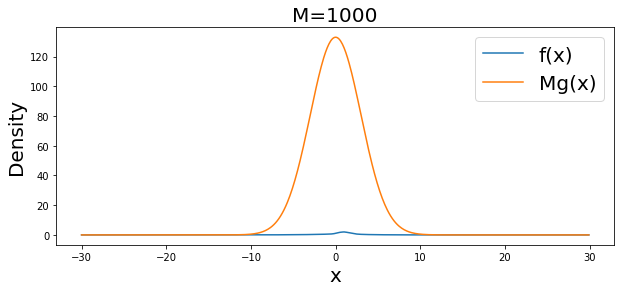

In [12]:
plot_target_vs_proposal(1000)

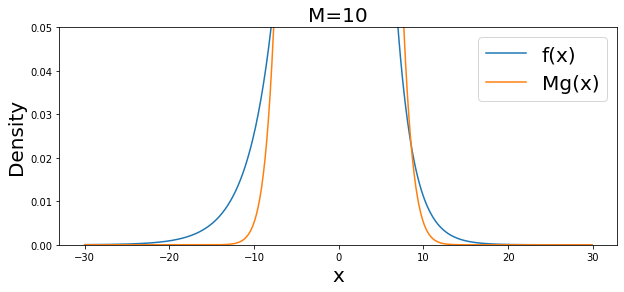

In [13]:
plot_target_vs_proposal(10, zoom=True)

We see that even for `M = 1000` $Mg(x)$ is not above the blue line!

### Accept Reject Algorithm

In [23]:
M = 1000
N = 1000000

In [18]:
def accept_reject():

    #collect all accepted samples here
    samples = []

    #try this many candidates
    for _ in range(N):

        #sample a candidate
        candidate = cd.sample()[0]

        #calculate probability of accepting this candidate
        prob_accept = f(candidate) / (M * cd.get_likelihood_of_sample(candidate))

        #accept with the calculated probability
        if np.random.random() < prob_accept:
            samples.append(candidate)
    return samples

In [19]:
%%time
samples = accept_reject()

CPU times: user 6.42 s, sys: 36 ms, total: 6.45 s
Wall time: 6.49 s


In [20]:
print("Num Samples Collected: %s"%len(samples)) # out of 1,000,000 samples we only accepted 6834

Num Samples Collected: 6745


In [24]:
print("Efficiency: %s"%round(len(samples) / N, 3)) # accepted less than 1% of samples. This was due to size of M

Efficiency: 0.007


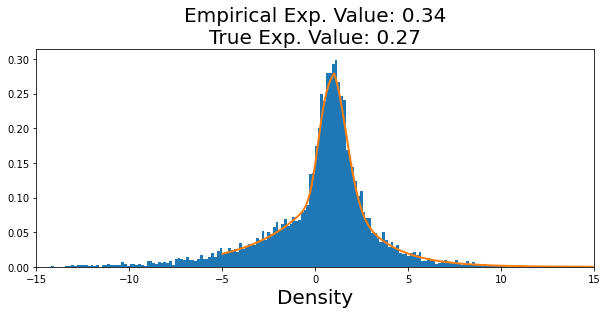

In [25]:
plt.figure(figsize=(10,4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f/NORM_CONST for f in f_vals], linewidth=2)
plt.xlim(-15,15)

plt.title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(samples), 2), round(np.mean(TRUE_EXP), 2)), fontsize=20)
plt.show()

### Case 2: Accept-Reject with $N(1,4)$ Candidate 

In [26]:
cd = CandidateDistribution(NormalDist, mu=1, sigma=4)

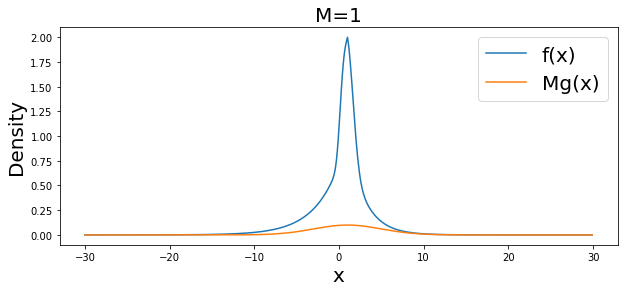

In [27]:
plot_target_vs_proposal()

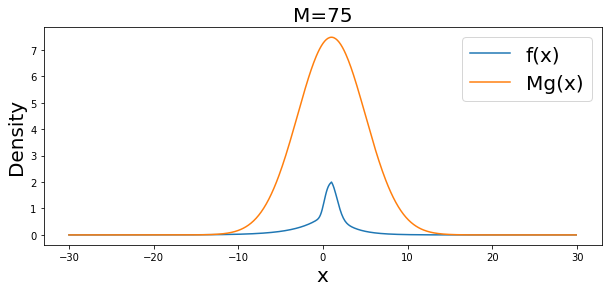

In [28]:
plot_target_vs_proposal(M=75)

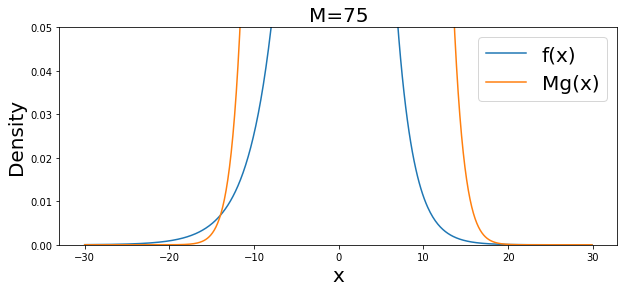

In [29]:
plot_target_vs_proposal(M=75, zoom=True)

In [ ]:
M=75

In [38]:
%%time
samples = accept_reject()

CPU times: user 6.09 s, sys: 25.9 ms, total: 6.12 s
Wall time: 6.15 s


In [39]:
print("Num Samples Collected: %s"%len(samples))

Num Samples Collected: 90439


In [40]:
print("Efficiency: %s"%round(len(samples) / N, 3))

Efficiency: 0.09


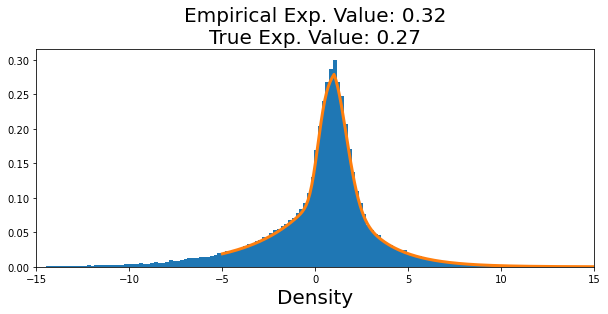

In [44]:
plt.figure(figsize=(10,4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f/NORM_CONST for f in f_vals], linewidth=3)
plt.xlim(-15,15)

plt.title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(samples), 2), round(np.mean(TRUE_EXP), 2)), fontsize=20)
plt.show()

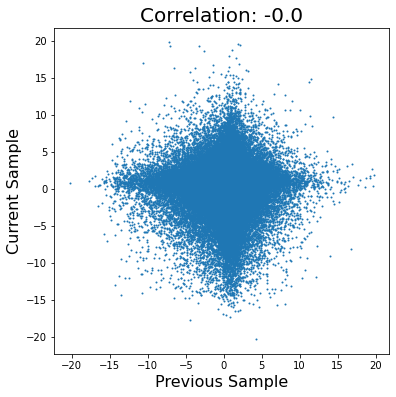

In [45]:
plt.figure(figsize=(6,6))
plt.scatter(samples[:-1], samples[1:], s=1)
plt.xlabel('Previous Sample', fontsize=16)
plt.ylabel('Current Sample', fontsize=16)
corr = round(pearsonr(samples[:-1], samples[1:])[0], 2)
plt.title('Correlation: %s'%corr, fontsize=20)
plt.show()

### Case 3: Metropolis Algorithm $N(x_{prev}, 4)$ candidate